## CUSTOMER ANALYSIS

In [8]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display         import Image
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import pydotplus         as pdp
import numpy as np
import hdbscan

In [9]:
import os
os.getcwd()


'd:\\TAI LIEU\\KHAI PHÁ DỮ LIỆU\\ĐỒ ÁN CUỐI KỲ\\DM\\notebooks'

In [10]:
df= pd.read_csv("../data/processed/bank_marketing_raw.csv")

In [11]:
cus_df = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'target']]

In [12]:
for col in cus_df.columns:
    print(f"\n===== Column: {col} =====")
    pct = pd.crosstab(df[col], df['target'], normalize='index').sort_values(by = [1], ascending=[False])
    print(pct.round(3))


===== Column: age =====
target      0      1
age                 
90      0.000  1.000
92      0.000  1.000
93      0.000  1.000
85      0.200  0.800
87      0.250  0.750
..        ...    ...
44      0.918  0.082
50      0.923  0.077
88      1.000  0.000
89      1.000  0.000
94      1.000  0.000

[77 rows x 2 columns]

===== Column: job =====
target             0      1
job                        
student        0.713  0.287
retired        0.772  0.228
unemployed     0.845  0.155
management     0.862  0.138
admin.         0.878  0.122
self-employed  0.882  0.118
technician     0.889  0.111
services       0.911  0.089
housemaid      0.912  0.088
entrepreneur   0.917  0.083
blue-collar    0.927  0.073

===== Column: marital =====
target        0      1
marital               
single    0.851  0.149
divorced  0.881  0.119
married   0.899  0.101

===== Column: education =====
target         0      1
education              
tertiary   0.850  0.150
secondary  0.894  0.106
primary    0.914  0

## ĐƠN BIẾN

### AGE

**Phân nhóm độ tuổi theo giai đoạn vòng đời tài chính của khách hàng**

Các nhóm tuổi được chia thành các giai đoạn trong cuộc đời với:
- Formative Years: từ 0 đến 18 tuổi
- Early Career: từ 18 đến 25 tuổi
- Mid-Career: từ 25 đến 45 tuổi
- 'Pre-Retirement: từ 45 đến 65 tuổi
- Retirement: 65 tuổi trở lên

Phân chia tuổi khách hàng theo phương pháp này cho thấy sự **thiên lệch** trong số lượng khách hàng ở mỗi nhóm tuổi khi nhóm Mid-Career chiếm hơn 65% toàn bộ khách hàng, nhóm Pre-Retirement chiếm khoảng 30%. Trong khi tổng khách hàng trong 3 nhóm tuổi còn lại chỉ chiếm 5%


In [13]:
cus_df['age_group_1'] = pd.cut(cus_df['age'], bins= [0, 18, 25, 45, 65, 120],
                             labels= ['Formative Years', 'Early Career', 'Mid-Career', 'Pre-Retirement', 'Retirement'],
                             right= True)
ag1_count = cus_df.groupby('age_group_1').size()
ag1_count = pd.DataFrame(ag1_count).reset_index()
ag1_count


C:\Users\ACER\AppData\Local\Temp\ipykernel_20892\234245647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df['age_group_1'] = pd.cut(cus_df['age'], bins= [0, 18, 25, 45, 65, 120],
C:\Users\ACER\AppData\Local\Temp\ipykernel_20892\234245647.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ag1_count = cus_df.groupby('age_group_1').size()


,age_group_1,0
0,Formative Years,12
1,Early Career,1324
2,Mid-Career,29427
3,Pre-Retirement,13697
4,Retirement,751


**Nhận xét:**

Tỷ lệ thành công của chiến dịch ở nhóm Formative Years là cao nhất với 58%. Kế đến là nhốm Retirement và Early Career với 43% và 24%. Hai nhóm tuổi Pre-Retirement và Mid-Career chỉ đạt tỷ lệ thành công ở mức 11%.

Khi phân nhóm độ tuổi theo chu kỳ tài chính, số lượng khách hàng giữa các nhóm có sự chênh lệch đáng kể. Mặc dù chu kỳ tài chính phù hợp cho mục đích diễn giải, nhưng chưa tối ưu để đánh giá hiệu quả chiến dịch do sự mất cân bằng về phân bố mẫu. Vì vậy, bên cạnh tỷ lệ thành công, cần xem xét thêm các thước đo chuẩn hóa khác để đánh giá toàn diện hơn tác động của độ tuổi đến khả năng subscribe deposit.

In [14]:

pct_age = pd.crosstab(cus_df['age_group_1'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_age = pd.DataFrame(pct_age.reset_index())

pct_age

target,age_group_1,0,1
0,Formative Years,0.42,0.58
1,Retirement,0.57,0.43
2,Early Career,0.76,0.24
3,Pre-Retirement,0.89,0.11
4,Mid-Career,0.89,0.11


Text(0.5, 1.0, 'Subcription Rate By Age Group')

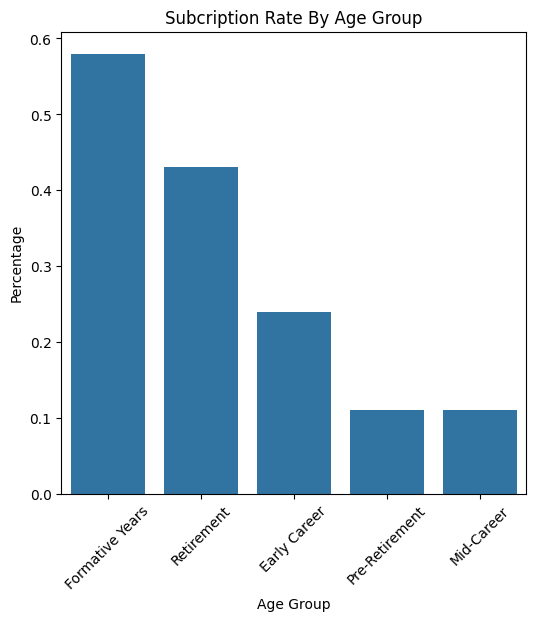

In [15]:
order = pct_age.sort_values(by=1, ascending=False)['age_group_1']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_age, x= 'age_group_1', y= 1, order=order)
plt.tick_params(axis='x', rotation= 45)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Age Group')

**Phân nhóm độ tuổi sử dụng Decision Tree nhằm xác định các ngưỡng phân tách tối ưu theo dữ liệu**

In [16]:
age_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05)
age_tree.fit(df[['age']], df['target'])


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",0.05
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre


(process:19364): Pango-CRITICAL **: 18:42:19.130: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19364): Pango-CRITICAL **: 18:42:19.132: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19364): Pango-CRITICAL **: 18:42:19.133: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:19364): Pango-CRITICAL **: 18:42:19.133: pango_font_description_get_family: assertion 'desc != NULL' failed



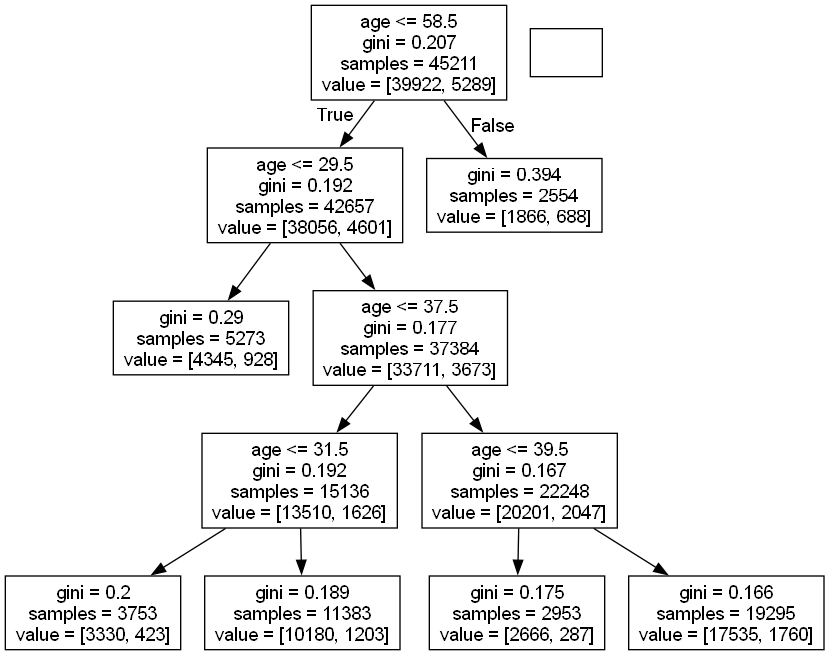

In [17]:
## Biểu diễn cây quyết định
dcs_tree = tree.export_graphviz(age_tree, out_file = None, feature_names = ['age'])
graph    = pdp.graph_from_dot_data(dcs_tree)
Image(graph.create_png())

**Nhận xét:**

Từ kết quả của Cây quyết định, độ tuổi khách hàng được chia thành 4 nhóm:
- Từ 0 đến 29 tuổi (chiếm 12%)
- Từ 29 tuổi đến 37 tuổi (chiếm 33%)
- Từ 37 tuổi đến 58 tuổi (chiếm 49%)
- Trên 58 tuổi (chiếm 6%)

In [18]:
cus_df.loc[:,'age_group_2'] = pd.cut(cus_df.loc[:,'age'], bins= [0, 29.5, 37.5, 58.5, 120],
                             labels= ['< 29', '29 - 37', '37-58', '> 58'],
                             right= True)
ag2_count = cus_df.groupby('age_group_2', observed=True).size()
ag2_count = pd.DataFrame(ag2_count).reset_index()
ag2_count

C:\Users\ACER\AppData\Local\Temp\ipykernel_20892\1322626860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df.loc[:,'age_group_2'] = pd.cut(cus_df.loc[:,'age'], bins= [0, 29.5, 37.5, 58.5, 120],


,age_group_2,0
0,< 29,5273
1,29 - 37,15136
2,37-58,22248
3,> 58,2554


**Nhận xét:**

Nhóm khách hàng trên 58 tuổi có tỷ lệ đăng ký tiền gửi có kỳ hạn cao nhất, rơi vào 27%

Nhóm khách hàng dưới 29 tuổi có tỷ lệ đăng ký tiền gửi có kỳ hạn khoảng 18%

Các nhóm 29-37 tuổi và 37-58 tuối chỉ đạt tỷ lệ 11% và 9%

--> Nhóm khách hàng trên 58 tuổi có xu hướng đăng ký cao hơn, tuy nhiên mối quan hệ giữa độ tuổi và khả năng đăng ký tiền gửi có kỳ hạn vẫn là chưa rõ ràng

--> Độ tuổi chỉ đóng vai trò hỗ trợ trong phân tích và cần được kết hợp với các biến khác để đánh giá hiệu quả toàn diện hơn

In [19]:
pct_age = pd.crosstab(cus_df['age_group_2'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_age = pd.DataFrame(pct_age.reset_index())
pct_age

target,age_group_2,0,1
0,> 58,0.73,0.27
1,< 29,0.82,0.18
2,29 - 37,0.89,0.11
3,37-58,0.91,0.09


Text(0.5, 1.0, 'Subcription Rate By Age Group')

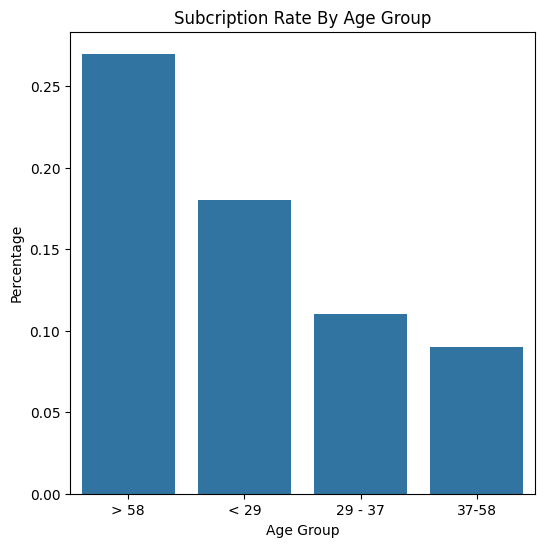

In [20]:
order = pct_age.sort_values(by=1, ascending=False)['age_group_2']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_age, x= 'age_group_2', y= 1, order=order)
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Age Group')

### BALANCE

**Phân nhóm số dư tài khoản bằng optimal binning**

Biến số dư tài khoản được chia khoảng bằng phương pháp optimal binning nhằm tối đa hóa sự khác biệt về tỷ lệ đăng ký tiền gửi giữa các nhóm

Số dư tài khoản của khách hàng được chia thành các khoảng:
- Từ vô cùng đến - 46.5
- Từ -46.5 đến 60.5
- Từ 60.5 đến 798.5
- Từ 798.5 đến 1578.5
- Lớn hơn 1578.5

Các khoảng chia này cho thấy event rate (tỷ lệ khách hàng đăng ký) ở các bin phân biệt rõ với nhau và tăng đều theo bin

Kích thước của các bin cũng là hợp lý, bin lớn nhất chiến khoảng 39% - vẫn chấp nhận được

Không có hiện tượng thiên lệch mẫu khi bin có event rate cao nhất vẫn có mức count chỉ khoảng 23%


In [21]:
from optbinning import OptimalBinning

optb = OptimalBinning(
    name="balance",
    dtype="numerical",
    max_n_bins=5
)

optb.fit(cus_df['balance'], cus_df['target'])

binning_table = optb.binning_table.build()
binning_table


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -46.50)",3193,0.070624,3027,166,0.051989,0.882041,0.039195,0.004747
1,"[-46.50, 60.50)",7628,0.168720,7034,594,0.077871,0.450333,0.028770,0.003566
2,"[60.50, 798.50)",17577,0.388777,15614,1963,0.111680,0.052396,0.001046,0.000131
3,"[798.50, 1578.50)",6369,0.140873,5521,848,0.133145,-0.147865,0.003259,0.000407
4,"[1578.50, inf)",10444,0.231006,8726,1718,0.164496,-0.396152,0.042091,0.005227
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,45211,1.000000,39922,5289,0.116985,,0.114360,0.014078


**Nhận xét**

Nhóm khách hàng có số dư tài khoản trên 1578.5 có tỷ lệ đăng ký tiền gửi có kỳ hạn cao nhất với 16%

Tỷ lệ đăng ký có xu hướng tăng dần theo mức số dư tài khoản, từ 5% ở mức thấp nhất lên đến khoảng 16% ở nhóm có số dư cao

--> Balance có mối liên hệ tích cực với khả năng đăng ký tiền gửi. Tuy nhiên mức chênh lệch giữa các nhóm là không quá lớn, cho thấy balance không phải là yếu tố duy nhất ảnh hưởng đến quyết định của khách hàng

In [22]:
cus_df.loc[:, 'balance_group'] = pd.cut(cus_df.loc[:, 'balance'], bins= [-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],
                                 labels= ['< -46.5', '-46.5 - 60.5', '60.5 - 798.5', '798.5 - 1578.5', '> 1578.5'],
                                 right= False)

pct_balance = pd.crosstab(cus_df['balance_group'], cus_df['target'], 
                      normalize='index').sort_values(by= 1, ascending=False).round(2)
pct_balance = pd.DataFrame(pct_balance.reset_index())
pct_balance

C:\Users\ACER\AppData\Local\Temp\ipykernel_20892\5369981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df.loc[:, 'balance_group'] = pd.cut(cus_df.loc[:, 'balance'], bins= [-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],


target,balance_group,0,1
0,> 1578.5,0.84,0.16
1,798.5 - 1578.5,0.87,0.13
2,60.5 - 798.5,0.89,0.11
3,-46.5 - 60.5,0.92,0.08
4,< -46.5,0.95,0.05


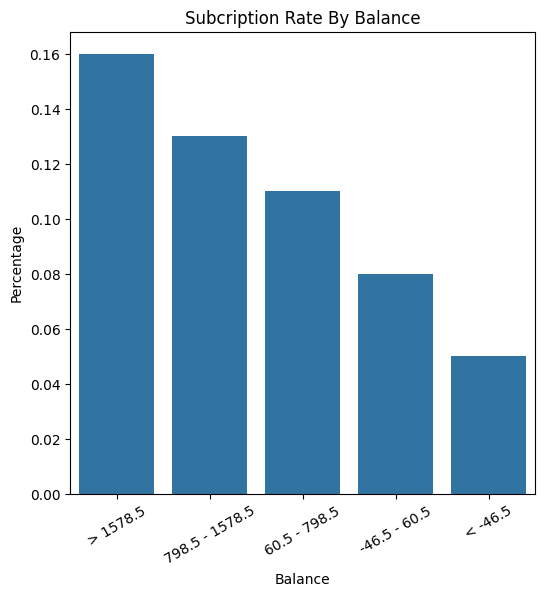

In [23]:
order = pct_balance.sort_values(by=1, ascending=False)['balance_group']
plt.figure(figsize=(6, 6))
sns.barplot(data= pct_balance, x= 'balance_group', y= 1, order=order)
plt.xlabel('Balance')
plt.ylabel('Percentage')
plt.title('Subcription Rate By Balance')
plt.tick_params(axis= 'x', rotation= 30)

### JOB

In [24]:
pct_job = pd.crosstab(
    cus_df['job'],
    cus_df['target'],
    normalize='index'
).round(3).reset_index()

pct_job = pct_job.sort_values(by=1, ascending=False)
pct_job


target,job,0,1
8,student,0.713,0.287
5,retired,0.772,0.228
10,unemployed,0.845,0.155
4,management,0.862,0.138
0,admin.,0.878,0.122
6,self-employed,0.882,0.118
9,technician,0.889,0.111
7,services,0.911,0.089
3,housemaid,0.912,0.088
2,entrepreneur,0.917,0.083


**Nhận xét**

Kết quả cho thấy nghề nghiệp có mối liên hệ rõ ràng với khả năng đăng ký tiền gửi có kỳ hạn. Nhóm *student* và *retired* có tỷ lệ đăng ký cao nhất (28.7% và 22.8%), trong khi các nhóm như *blue-collar*, *entrepreneur* và *services* có tỷ lệ đăng ký thấp nhất, chỉ khoảng 7–9%. Mức chênh lệch đáng kể giữa các nhóm nghề cho thấy hành vi tài chính của khách hàng khác nhau theo nghề nghiệp. Tuy nhiên, đây mới là phân tích đơn biến, do đó cần tiếp tục xem xét nghề nghiệp trong mối quan hệ kết hợp với các biến khác, đặc biệt là độ tuổi, để đánh giá đầy đủ vai trò của biến này.


Text(0.5, 1.0, 'Subscription Rate by Job')

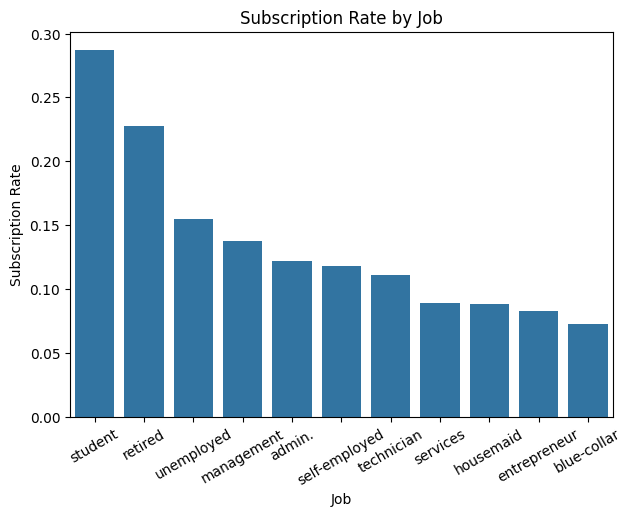

In [25]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=pct_job,
    x='job',
    y=1,
    order=pct_job['job']
)
plt.xticks(rotation=30)
plt.xlabel('Job')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Job')


### HOUSING

In [26]:
housing_df = cus_df[['housing', 'target']].copy()
housing_dist = housing_df['housing'].value_counts(normalize=True).round(3)
housing_dist

housing
yes    0.556
no     0.444
Name: proportion, dtype: float64

In [27]:
pct_housing = pd.crosstab(
    housing_df['housing'],
    housing_df['target'],
    normalize='index'
).round(3)

pct_housing


target,0,1
housing,,
no,0.833,0.167
yes,0.923,0.077


**Housing  Analysis**

Xét theo tỷ lệ đăng ký tiền gửi có kỳ hạn (target = 1):

- Nhóm **không có vay mua nhà** đạt tỷ lệ đăng ký **16.7%**
- Nhóm **có vay mua nhà** chỉ đạt **7.7%**

Sự chênh lệch đáng kể này cho thấy **home loan có mối quan hệ nghịch với khả năng đăng ký tiền gửi có kỳ hạn**. Khách hàng đang gánh khoản vay mua nhà thường có **dòng tiền nhàn rỗi thấp hơn**, do đó ít có xu hướng tham gia các sản phẩm tiết kiệm dài hạn.

Tuy nhiên, do biến `housing` chỉ phản ánh một chiều nghĩa vụ tài chính, nên **chưa đủ để kết luận hành vi khách hàng một cách toàn diện**. Biến này cần được **kết hợp với các đặc điểm nhân khẩu học và nghề nghiệp** để làm rõ vai trò của thu nhập, độ ổn định tài chính và giai đoạn sự nghiệp đối với quyết định gửi tiền có kỳ hạn.


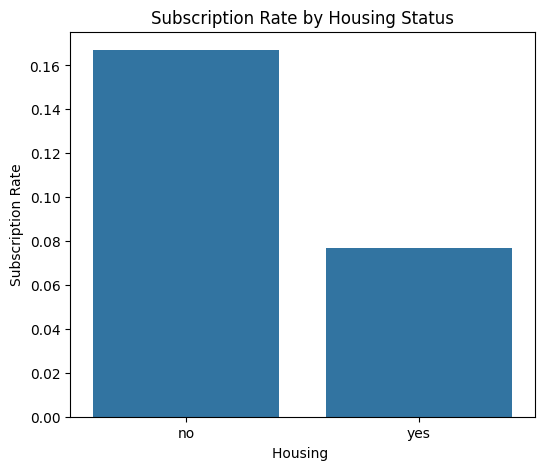

In [28]:
pct_housing_plot = pct_housing.reset_index()

plt.figure(figsize=(6,5))
sns.barplot(
    data=pct_housing_plot,
    x='housing',
    y=1
)
plt.xlabel('Housing ')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Housing Status')
plt.show()


### LOAN

In [29]:
cus_df['loan'].value_counts(normalize=True).round(3)

loan
no     0.84
yes    0.16
Name: proportion, dtype: float64

In [30]:
loan_target = pd.crosstab(
    cus_df['loan'],
    cus_df['target'],
    normalize='index'
).round(3)

loan_target


target,0,1
loan,,
no,0.873,0.127
yes,0.933,0.067


Text(0.5, 1.0, 'Subscription Rate by Loan')

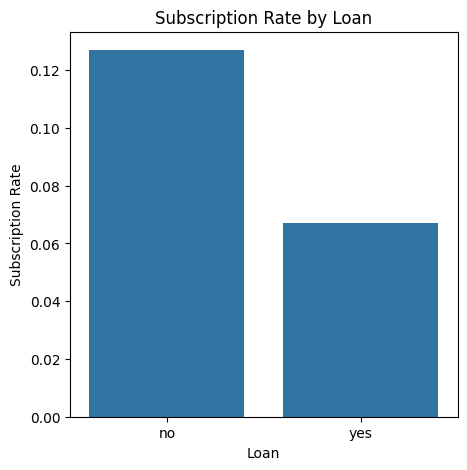

In [31]:
loan_target = loan_target.reset_index()

plt.figure(figsize=(5,5))
sns.barplot(data=loan_target, x='loan', y=1)
plt.xlabel('Loan')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Loan')


## ĐA BIẾN

### JOB & HOUSING

In [32]:
X = df[['job', 'housing']]
y = df['target']
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['job', 'housing'])
    ]
)

dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=0.05,
    random_state=42
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', dt)
])

model.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse ma

In [33]:
feature_names = model.named_steps['preprocess'] \
    .get_feature_names_out()

importances = model.named_steps['model'].feature_importances_

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values(by='importance', ascending=False)
)

feature_importance_df


,feature,importance
11,cat__housing_yes,0.809835
0,cat__job_blue-collar,0.138777
8,cat__job_technician,0.040799
6,cat__job_services,0.007551
3,cat__job_management,0.003037
1,cat__job_entrepreneur,0.000000
2,cat__job_housemaid,0.000000
4,cat__job_retired,0.000000
7,cat__job_student,0.000000
5,cat__job_self-employed,0.000000


**NHẬN XÉT**

Khách hàng **không có khoản vay mua nhà (housing = no)** có khả năng đăng ký tiền gửi có kỳ hạn cao hơn đáng kể, bất kể nghề nghiệp. Điều này cho thấy việc không chịu áp lực tài chính dài hạn giúp khách hàng sẵn sàng tham gia các sản phẩm tiết kiệm hơn.

Ngược lại, khách hàng **có vay mua nhà (housing = yes)** nhìn chung có xu hướng không đăng ký tiền gửi có kỳ hạn. Trong nhóm này, khách hàng làm nghề **blue-collar** là phân khúc có khả năng đăng ký thấp nhất, cho thấy sự kết hợp giữa thu nhập không ổn định và nghĩa vụ vay dài hạn làm giảm đáng kể khả năng tham gia sản phẩm.

Đối với các nhóm nghề nghiệp còn lại, khi đã xét đến yếu tố vay mua nhà, sự khác biệt về khả năng đăng ký là không rõ ràng. Điều này cho thấy nghề nghiệp chỉ đóng vai trò bổ trợ trong phân tích và không phải là yếu tố quyết định chính.


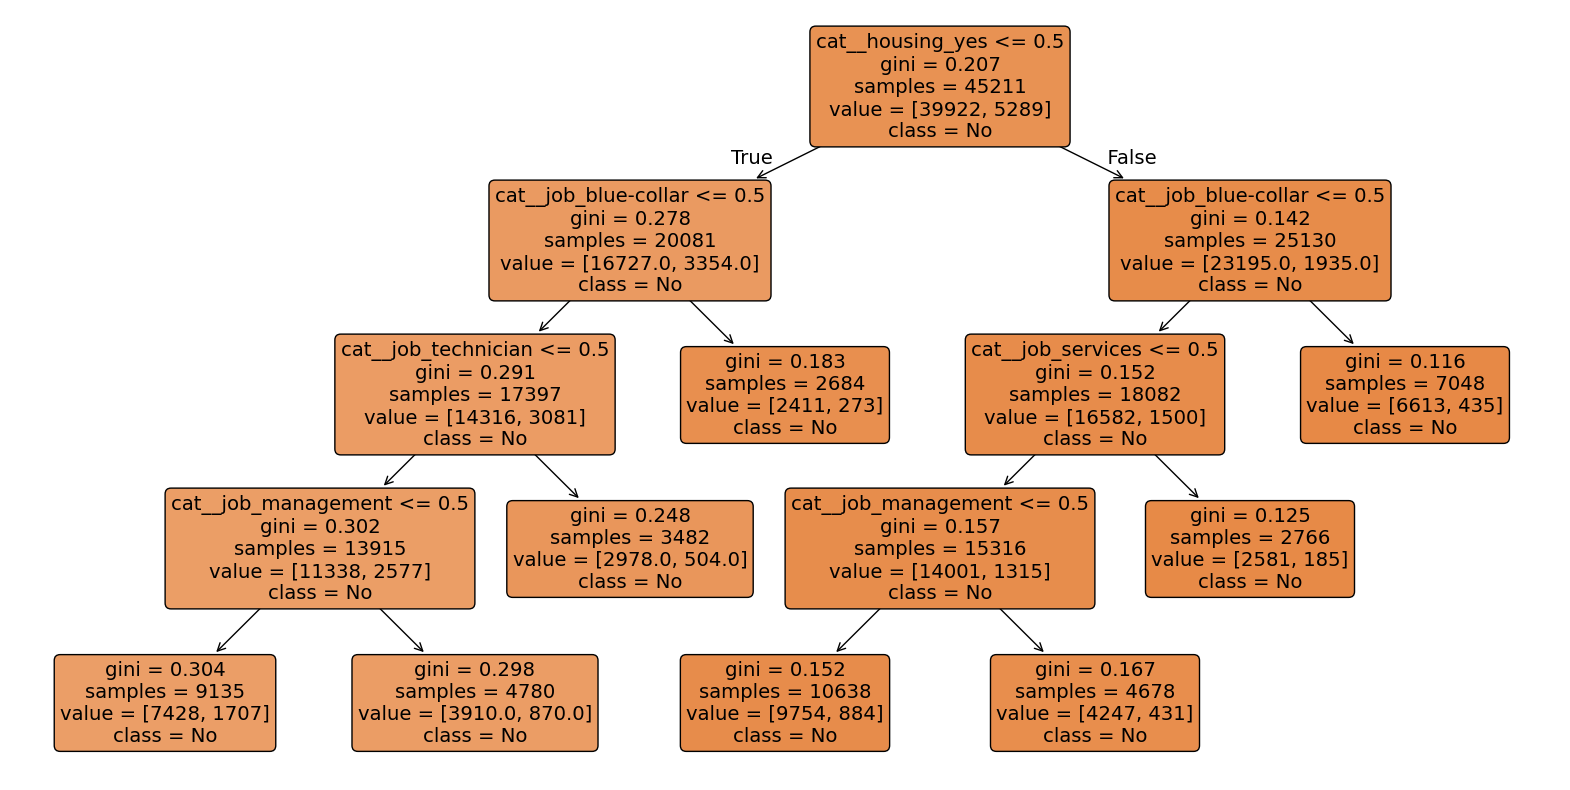

In [34]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
tree.plot_tree(
    model.named_steps['model'],
    feature_names=feature_names,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True
)
plt.show()

### BALANCE & LOAN

In [35]:
balance_loan = pd.crosstab(
    [cus_df['balance_group'], cus_df['loan']],
    cus_df['target'],
    normalize='index'
).round(3)

balance_loan


target                   0      1
balance_group  loan              
< -46.5        no    0.951  0.049
               yes   0.943  0.057
-46.5 - 60.5   no    0.918  0.082
               yes   0.940  0.060
60.5 - 798.5   no    0.880  0.120
               yes   0.932  0.068
798.5 - 1578.5 no    0.855  0.145
               yes   0.939  0.061
> 1578.5       no    0.827  0.173
               yes   0.914  0.086

**Balance × Loan**

Kết quả cho thấy khoản vay cá nhân làm suy yếu rõ rệt tác động tích cực của số dư tài khoản lên khả năng đăng ký tiền gửi có kỳ hạn.

- Ở các nhóm balance thấp (< -46.5 và -46.5 – 60.5), tỷ lệ đăng ký đều thấp và chênh lệch giữa khách hàng có và không vay cá nhân là không đáng kể (dao động từ 4.9% đến 8.2%).

- Tuy nhiên, từ nhóm balance trung bình trở lên, sự khác biệt trở nên rõ ràng. Ở nhóm 60.5 – 798.5, khách hàng không vay cá nhân có tỷ lệ đăng ký 12.0%, cao gần gấp đôi so với nhóm đang vay (6.8%). Khoảng cách này tiếp tục mở rộng ở nhóm balance cao nhất (> 1578.5), với tỷ lệ đăng ký lần lượt là 17.3% (loan = no) và 8.6% (loan = yes).

=> Mặc dù balance cao làm tăng khả năng đăng ký, tác động này bị hạn chế rõ rệt khi khách hàng đang có khoản vay cá nhân, cho thấy loan là yếu tố kìm hãm hành vi tham gia tiết kiệm dài hạn.

In [36]:
X = cus_df[['balance_group', 'loan']]
y = cus_df['target']

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), ['balance_group', 'loan'])
])

logit = Pipeline([
    ('prep', preprocess),
    ('lr', LogisticRegression(max_iter=1000))
])

logit.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,th

In [37]:
coef = logit.named_steps['lr'].coef_[0]
features = logit.named_steps['prep'].get_feature_names_out()

pd.DataFrame({
    'feature': features,
    'coef': coef
}).sort_values(by='coef')

,feature,coef
4,cat__loan_yes,-0.591512
2,cat__balance_group_< -46.5,-0.353080
0,cat__balance_group_60.5 - 798.5,0.387493
1,cat__balance_group_798.5 - 1578.5,0.573347
3,cat__balance_group_> 1578.5,0.804796


**Nhận xét Balance × Loan**

Biến loan_yes có hệ số -0.59, cho thấy việc có khoản vay cá nhân làm giảm đáng kể xác suất đăng ký tiền gửi có kỳ hạn, ngay cả khi đã kiểm soát theo mức số dư tài khoản.

Ảnh hưởng của balance thể hiện rõ xu hướng đồng biến với khả năng đăng ký:

- Nhóm balance < -46.5 có hệ số -0.35, cho thấy khả năng đăng ký thấp hơn đáng kể so với nhóm tham chiếu.

- Khi balance tăng, hệ số logistic tăng dần:

    - 60.5 – 798.5: +0.39

    - 798.5 – 1578.5: +0.57

    - lớn hơn 1578.5: +0.80

Điều này cho thấy balance cao làm tăng mạnh xác suất đăng ký, tuy nhiên tác động tích cực này bị suy giảm đáng kể nếu khách hàng đang có khoản vay cá nhân.

### BALANCE & HOUSING

In [38]:
cus_df.groupby('housing')['balance'].describe()

,count,mean,std,min,25%,50%,75%,max
housing,,,,,,,,
no,20081.0,1596.501270,3613.405339,-8019.0,85.0,507.0,1708.00,102127.0
yes,25130.0,1175.103064,2483.285761,-4057.0,62.0,412.0,1257.75,58544.0


In [39]:
cus_df['balance_group'] = pd.cut(
    cus_df['balance'],
    bins=[-9999, -46.5, 60.5, 798.5, 1578.5, 99999999],
    labels=['< -46.5', '-46.5 - 60.5', '60.5 - 798.5', 
            '798.5 - 1578.5', '> 1578.5'],
    right=False
)


C:\Users\ACER\AppData\Local\Temp\ipykernel_20892\2408808782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_df['balance_group'] = pd.cut(


In [40]:
cus_df[['balance', 'balance_group']].head()

,balance,balance_group
0,2143,> 1578.5
1,29,-46.5 - 60.5
2,2,-46.5 - 60.5
3,1506,798.5 - 1578.5
4,1,-46.5 - 60.5


In [41]:
balance_housing = pd.crosstab(
    [cus_df['balance_group'], cus_df['housing']],
    cus_df['target'],
    normalize='index'
).round(3)
balance_housing

target                      0      1
balance_group  housing              
< -46.5        no       0.952  0.048
               yes      0.947  0.053
-46.5 - 60.5   no       0.912  0.088
               yes      0.933  0.067
60.5 - 798.5   no       0.831  0.169
               yes      0.930  0.070
798.5 - 1578.5 no       0.813  0.187
               yes      0.910  0.090
> 1578.5       no       0.773  0.227
               yes      0.901  0.099

**Nhận xét ngắn gọn từ số liệu**

- Ở các nhóm **balance** thấp, tỷ lệ đăng ký tiền gửi giữa khách hàng có và không vay mua nhà gần như không khác biệt.

- Từ nhóm **balance** trung bình trở lên, sự khác biệt trở nên rất rõ ràng:

- Khách hàng không vay mua nhà có tỷ lệ đăng ký cao gấp khoảng 2 lần so với khách hàng đang vay mua nhà, dù có cùng mức số dư.

- Khoảng cách lớn nhất xuất hiện ở nhóm **balance** cao nhất (22.7% so với 9.9%), cho thấy tác động kìm hãm mạnh của khoản vay mua nhà lên hành vi tiết kiệm.

### BALANCE & HOUSING & LOAN

In [42]:
X = cus_df[['balance', 'housing', 'loan']]
y = cus_df['target']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['housing', 'loan'])
    ],
    remainder='passthrough'
)
dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=0.05,
    random_state=42
)

pipe = Pipeline([
    ('prep', preprocess),
    ('tree', dt)
])

pipe.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('tree', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse ma

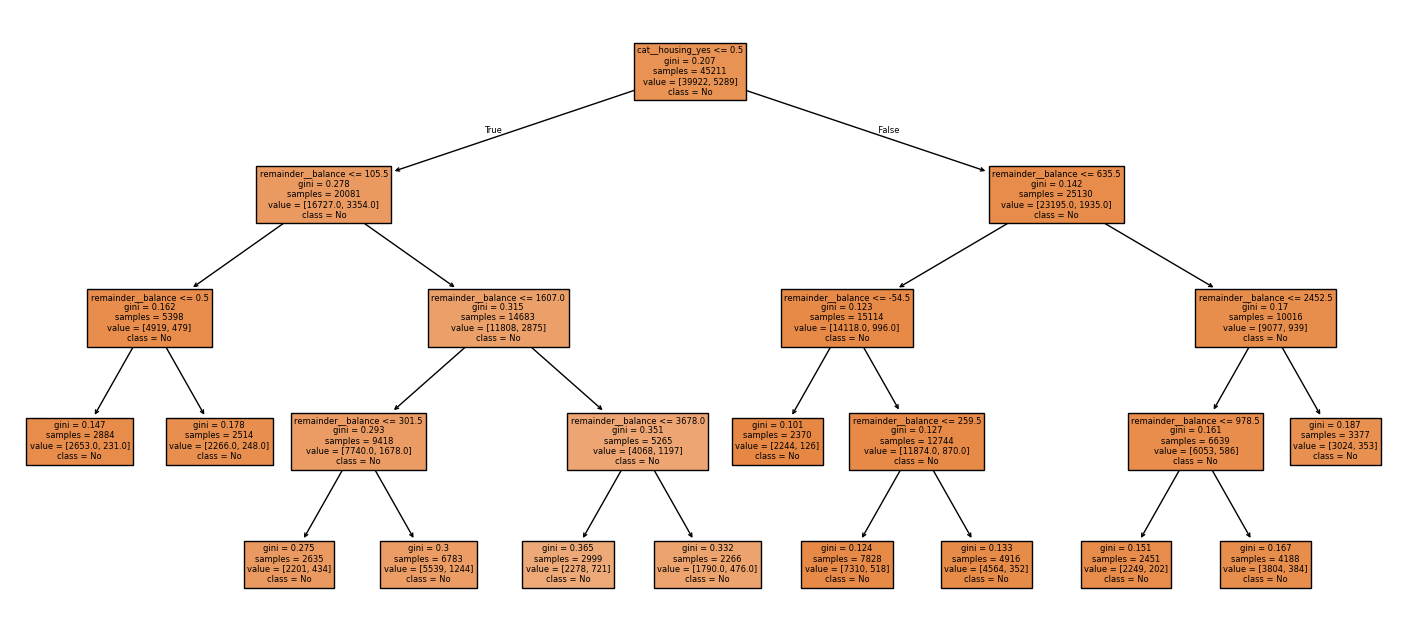

In [43]:
plt.figure(figsize=(18,8))
tree.plot_tree(
    pipe.named_steps['tree'],
    feature_names=pipe.named_steps['prep'].get_feature_names_out(),
    class_names=['No', 'Yes'],
    filled=True
)
plt.show()

**Phân tích**
- Mô hình Decision Tree cho thấy housing loan là yếu tố có ảnh hưởng mạnh nhất đến khả năng khách hàng đăng ký tiền gửi có kỳ hạn, khi biến này được sử dụng làm tiêu chí phân tách ngay tại nút gốc.

- Đối với khách hàng có vay mua nhà, phần lớn các nhánh đều dẫn đến kết quả không đăng ký, ngay cả khi số dư tài khoản cao. Điều này cho thấy nghĩa vụ tài chính dài hạn tạo ra áp lực dòng tiền, làm giảm xu hướng tham gia các sản phẩm tiết kiệm.

- Ngược lại, với nhóm không vay mua nhà, biến balance bắt đầu phát huy vai trò phân tách. Khi balance tăng, xác suất đăng ký có xu hướng cải thiện, tuy nhiên mối quan hệ này không tuyến tính mà chỉ rõ rệt khi vượt qua một số ngưỡng nhất định.

=> Kết quả từ Decision Tree cho thấy nghĩa vụ tài chính dài hạn có tác động mạnh hơn số dư tài khoản hiện tại. Balance chỉ đóng vai trò thúc đẩy hành vi tiết kiệm khi khách hàng không chịu áp lực từ các khoản vay dài hạn. Knowledge này giúp giải thích rõ hành vi khách hàng và có giá trị thực tiễn trong phân khúc và thiết kế chiến dịch tiếp thị.


### HOUSING & BALANCE & AGE (Dùng tree)

In [44]:
dt_df = cus_df.drop(['age_group_1', 'age_group_2', 'balance_group'], axis = 1)
dt_feature = dt_df.drop(['target'], axis=1)
dt_target = dt_df['target']

In [45]:
cat_cols = dt_feature.select_dtypes(include='object').columns
dt_feature_enc = pd.get_dummies(dt_feature, columns=cat_cols, drop_first=True)

In [46]:
dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=4000,
    class_weight={0: 1, 1: 4},
    random_state=81
)

dt.fit(dt_feature_enc, dt_target)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",4000
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",81
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

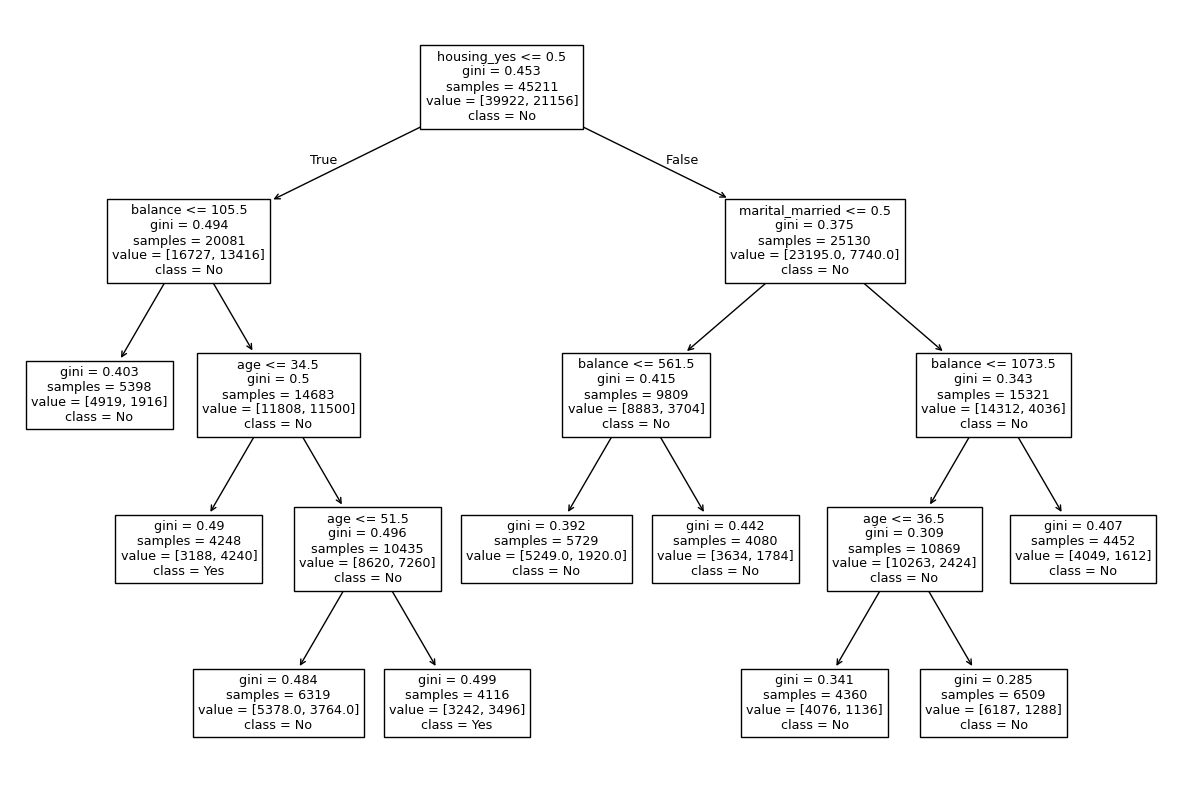

In [47]:
plt.figure(figsize=(15, 10))
tree.plot_tree(dt, feature_names=dt_feature_enc.columns, class_names=['No', 'Yes'])
plt.show()

**RULE**

1. housing = 0 and balance > 105.5 and age < 35 --> 4248 --> 9.4%
2. housing = 0 and balance > 105.5 and age > 51 --> 4116 --> 9.1%

**Nhận xét**

Các luật trích xuất cho thấy nhóm khách hàng không vay mua nhà và có số dư tài khoản lớn hơn 105.5 là nhóm có tiềm năng đăng ký tiền gửi định kỳ

Đặc biệt, hai phân khúc tuổi dưới 35 và trên 51 lần lượt đạt 9.4% và 9.1%, cao hơn các nhóm tuổi khác

=> Độ tuổi kết hợp với tình trạng vay mua nhà và khả năng tài chính có ảnh hưởng đáng kể đến quyết định đăng ký tiền gửi có kỳ hạn

### HDBSCAN

In [48]:
clustering_df = cus_df.drop(['age_group_1', 'age_group_2', 'balance_group'], axis= 1)
df_ori = clustering_df.copy()
cate_cols = clustering_df.select_dtypes(include='object').columns

In [49]:
clustering_df = pd.get_dummies(clustering_df, columns=cate_cols, drop_first=True)

In [50]:
scaler = RobustScaler()
clustering_df_scaled = scaler.fit_transform(clustering_df)

In [51]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4000,
    min_samples=30, 
    core_dist_n_jobs=1
)
labels = clusterer.fit_predict(clustering_df_scaled)

In [52]:
df_ori['cluster'] = labels
df_ori.groupby('cluster')['target'].size()

cluster
-1    12166
 0     4038
 1    29007
Name: target, dtype: int64

In [53]:
df_ori.groupby(['cluster', 'target']).size()

cluster  target
-1       0          8994
         1          3172
 0       0          3961
         1            77
 1       0         26967
         1          2040
dtype: int64

In [54]:
from sklearn.metrics import silhouette_score

mask = df_ori['cluster'] != -1

X_sil = clustering_df_scaled[mask]
labels_sil = df_ori.loc[mask, 'cluster']
sil_score = silhouette_score(X_sil, labels_sil)
print("Silhouette score (without noise):", round(sil_score, 3))


Silhouette score (without noise): 0.032


In [55]:
df_ori.groupby(['cluster', 'target']).median(numeric_only=True)


age  balance
cluster target               
-1      0       42.0   1637.5
        1       41.0   1166.0
 0      0       44.0    332.0
        1       40.0    403.0
 1      0       38.0    344.0
        1       35.0    505.5

In [56]:
cat_cols = ['housing', 'loan', 'job', 'marital', 'education', 'default']

for col in cat_cols:
    print(f"\n=== {col} ===")
    display(
        df_ori
        .groupby(['cluster', 'target'])[col]
        .value_counts(normalize=True)
        .unstack()
        .round(2)
        .reset_index()
        
    )


=== housing ===


housing,cluster,target,no,yes
0,-1,0,0.52,0.48
1,-1,1,0.61,0.39
2,0,0,0.39,0.61
3,0,1,0.23,0.77
4,1,0,0.39,0.61
5,1,1,0.69,0.31



=== loan ===


loan,cluster,target,no,yes
0,-1,0,0.70,0.30
1,-1,1,0.85,0.15
2,0,0,0.86,0.14
3,0,1,1.00,NaN
4,1,0,0.87,0.13
5,1,1,1.00,NaN



=== job ===


job,cluster,target,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,-1,0,0.09,0.12,0.09,0.06,0.15,0.08,0.08,0.09,0.02,0.13,0.08
1,-1,1,0.12,0.14,0.04,0.03,0.18,0.10,0.06,0.09,0.03,0.14,0.06
2,0,0,0.02,0.95,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,0.14,0.16,0.02,0.02,0.25,0.04,0.02,0.11,0.02,0.21,0.01
5,1,1,0.12,0.09,NaN,NaN,0.36,0.10,NaN,0.04,0.09,0.20,NaN



=== marital ===


marital,cluster,target,divorced,married,single
0,-1,0,0.23,0.47,0.30
1,-1,1,0.19,0.49,0.31
2,0,0,0.05,0.95,NaN
3,0,1,NaN,1.00,NaN
4,1,0,0.09,0.61,0.30
5,1,1,0.00,0.55,0.45



=== education ===


education,cluster,target,primary,secondary,tertiary
0,-1,0,0.21,0.42,0.37
1,-1,1,0.15,0.48,0.37
2,0,0,0.81,0.19,NaN
3,0,1,0.73,0.27,NaN
4,1,0,0.06,0.63,0.31
5,1,1,0.05,0.51,0.45



=== default ===


default,cluster,target,no,yes
0,-1,0,0.92,0.08
1,-1,1,0.98,0.02
2,0,0,1.00,NaN
3,0,1,1.00,NaN
4,1,0,1.00,NaN
5,1,1,1.00,NaN


**Nhận xét**

HDBSCAN phân chia khách hàng thành hai phân khúc có đặc điểm nhân khẩu học và tài chính khá tương đồng về độ tuổi, số dư tài khoản, tình trạng hôn nhân và hầu hết đều không có khoản vay tiêu dùng và lịch sử vỡ nợ. Tuy nhiên, hai nhóm khác biệt rõ rệt về nghề nghiệp và trình độ học vấn.

Nhóm 1 chủ yếu gồm khách hàng làm việc trong lĩnh vực quản lý, có trình độ học vấn cao.

Nhóm 2 tập trung các khách hàng làm việc chân tay, hành chính hoặc đã nghỉ hưu, với trình độ học vấn chủ yếu đến cấp 2.

Phân tích hành vi cho thấy tình trạng vay mua nhà là yếu tố ảnh hưởng mạnh đến quyết định đăng ký tiền gửi có kỳ hạn ở cả hai nhóm. Trong nhóm khách hàng có đăng ký, tỷ lệ chưa vay mua nhà chiếm 75% ở nhóm 1 và 62% ở nhóm 2. Ngược lại, trong nhóm không đăng ký của nhóm khách hàng 2, 64% khách hàng đã vay mua nhà.

=> Ở cả hai nhóm, khách hàng chưa vay mua nhà có xu hướng đăng ký tiền gửi có kỳ hạn cao hơn. Đặc biệt, đối với nhóm khách hàng lao động phổ thông và nghỉ hưu (nhóm 2), việc đã vay mua nhà làm giảm mức độ hấp dẫn của sản phẩm tiền gửi có kỳ hạn.

In [66]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

apriori_df = cus_df[[
    'housing',
    'loan',
    'balance_group',
    'age_group_2',
    'job',
    'target'
]].copy()

apriori_df.head()

def row_to_transaction(row):
    return [f"{col}={row[col]}" for col in apriori_df.columns]

transactions = apriori_df.apply(row_to_transaction, axis=1).tolist()

transactions[:3]

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

df_tf = pd.DataFrame(te_array, columns=te.columns_)
df_tf.head()

frequent_itemsets = apriori(
    df_tf,
    min_support=0.05,
    use_colnames=True
)

frequent_itemsets.sort_values(by='support', ascending=False).head()

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(age_group_2=29 - 37),(housing=yes),0.334786,0.555838,0.210259,0.628039,1.129896,1.0,0.024172,1.194109,0.172820,0.309038,0.162555,0.503156
1,(age_group_2=29 - 37),(loan=no),0.334786,0.839774,0.282652,0.844279,1.005365,1.0,0.001508,1.028930,0.008021,0.316908,0.028117,0.590430
2,(age_group_2=29 - 37),(target=0),0.334786,0.883015,0.298821,0.892574,1.010825,1.0,0.003200,1.088980,0.016099,0.325166,0.081710,0.615492
3,(age_group_2=37-58),(loan=no),0.492093,0.839774,0.409060,0.831266,0.989869,1.0,-0.004187,0.949579,-0.019753,0.443278,-0.053098,0.659186
4,(age_group_2=37-58),(target=0),0.492093,0.883015,0.446816,0.907992,1.028286,1.0,0.012291,1.271460,0.054158,0.481331,0.213502,0.707002


**Nhóm 1 – Inhibiting Rules (Các luật ức chế hành vi đăng ký)**

In [ ]:
rules_negative = rules[
    rules['consequents'].astype(str).str.contains("target=0")
]

rules_negative = rules_negative[
    (rules_negative['confidence'] >= 0.6) &
    (rules_negative['lift'] > 1.2)
]

rules_negative = rules_negative.sort_values(
    by='lift',
    ascending=False
)

rules_negative[
    ['antecedents', 'consequents', 'support', 'confidence', 'lift']
].head(10)


,antecedents,consequents,support,confidence,lift
196,"(job=blue-collar, age_group_2=29 - 37)","(target=0, housing=yes)",0.054013,0.760748,1.482827
324,"(loan=no, balance_group=60.5 - 798.5, job=blue...","(target=0, housing=yes)",0.053107,0.725378,1.413884
124,(balance_group=< -46.5),"(target=0, housing=yes)",0.050607,0.716567,1.396712
264,"(balance_group=60.5 - 798.5, job=blue-collar)","(target=0, housing=yes)",0.062595,0.706264,1.376629
297,"(loan=no, job=blue-collar)","(target=0, housing=yes)",0.122625,0.688867,1.342719
153,(job=blue-collar),"(target=0, housing=yes)",0.146270,0.679511,1.324482
319,"(loan=no, age_group_2=37-58, job=blue-collar)","(target=0, housing=yes)",0.062175,0.649942,1.266848
237,"(age_group_2=37-58, job=blue-collar)","(target=0, housing=yes)",0.073212,0.638750,1.245031
158,(job=services),"(target=0, housing=yes)",0.057088,0.621329,1.211076


>Rule I1

IF job = blue-collar AND age_group = 29–37

THEN target = 0 AND housing = yes

confidence ≈ 76%

lift ≈ 1.48

➝ Khách hàng lao động phổ thông trong độ tuổi lao động chính, đang vay mua nhà, có xác suất rất cao không đăng ký tiền gửi có kỳ hạn.

>Rule I2

IF loan = no AND job = blue-collar

THEN target = 0 AND housing = yes

confidence ≈ 69%

lift ≈ 1.34

➝ Ngay cả khi không có vay cá nhân, khách hàng blue-collar vẫn ít có khả năng đăng ký nếu đang chịu nghĩa vụ vay mua nhà.

>Rule I3

IF balance_group = 60.5–798.5 AND job = blue-collar

THEN target = 0 AND housing = yes

confidence ≈ 71%

lift ≈ 1.38

➝ Mức số dư trung bình không đủ để bù đắp áp lực tài chính từ khoản vay mua nhà.

- Housing loan là rào cản tài chính mạnh nhất đối với hành vi đăng ký.

- Nghề nghiệp blue-collar kết hợp với nghĩa vụ vay dài hạn làm giảm đáng kể khả năng tiết kiệm.

- Các rule này xác nhận trực tiếp kết quả từ Decision Tree và Logistic Regression.

**Nhóm 2 – Profile-based Rules (Luật mô tả hồ sơ khách hàng đã đăng ký)**

In [ ]:
rules_profile = rules[
    rules['antecedents'].astype(str).str.contains("target=1")
]

rules_profile = rules_profile[
    (rules_profile['confidence'] >= 0.6) &
    (rules_profile['lift'] > 1.1)
]

rules_profile = rules_profile.sort_values(
    by='lift',
    ascending=False
)

rules_profile[
    ['antecedents', 'consequents', 'support', 'confidence', 'lift']
].head(10)


,antecedents,consequents,support,confidence,lift
141,"(loan=no, target=1)",(housing=no),0.069342,0.652445,1.468936
20,(target=1),(housing=no),0.074185,0.634146,1.427737
142,"(target=1, housing=no)",(loan=no),0.069342,0.934705,1.113044


>Rule P1

IF target = 1

THEN housing = no

confidence ≈ 63%

lift ≈ 1.43

➝ Phần lớn khách hàng đăng ký không có vay mua nhà, cho thấy mức độ ổn định tài chính cao.

>Rule P2

IF target = 1 AND loan = no

THEN housing = no

confidence ≈ 65%

lift ≈ 1.47

➝ Khách hàng không có vay cá nhân và đã đăng ký gần như không có nghĩa vụ vay dài hạn.

>Rule P3

IF target = 1 AND housing = no

THEN loan = no

confidence ≈ 93%

lift ≈ 1.11

➝ Nhóm khách hàng đăng ký có hồ sơ tài chính “sạch”, không chịu đồng thời cả vay ngắn hạn lẫn dài hạn.

- Hồ sơ khách hàng tiềm năng điển hình:

housing = no

loan = no

- Sự ổn định tài chính là đặc trưng quan trọng nhất của nhóm khách hàng đăng ký.

- Các rule này giải thích ngược cho các inhibiting rules đã phát hiện ở trên.